Create compression version of GPT-2 nad BERT model and save the memory =)

## cola example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [1]:
!nvidia-smi

Fri Aug  4 12:43:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:41:00.0 Off |                  N/A |
|  0%   25C    P8    26W / 370W |      2MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:61:00.0 Off |                  N/A |
|  0%   

In [2]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [3]:
import transformers
print (transformers.__version__)

4.31.0


In [4]:
def create_space_matrices(model):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        
        layer.intermediate.dense.create_UV()
          
        layer.output.dense.create_UV()
          
        #print ("new shape", layer.output.dense.weight.shape)
        #print ("\n\n")

    return model

In [5]:
def sparse_grad_linear(model, *args):
    print ("create bert with sparse grads")
    model = replace_bert_layers(model)
    print ("created bert with sparse grads")
    return model

In [6]:
from datasets import load_dataset
import pandas as pd

dataset_cola = load_dataset('glue', 'cola')
dataset_cola.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 8551, 'validation': 1043, 'test': 1063}

In [7]:
label_list = dataset_cola["train"].features["label"].names
num_labels = len(label_list)


In [8]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [9]:
set(pd.DataFrame(dataset_cola['train']).label)

{0, 1}

In [10]:
task_num_labels = num_labels

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
#model=model.to('cuda:2')

In [12]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
sentence1_key, sentence2_key = task_to_keys['cola']

In [13]:

def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        
        
        result = tokenizer.batch_encode_plus(*args, max_length=128, truncation=True, padding="max_length")

        result["label"] = examples["label"]
        return result

In [14]:



num_labels

2

In [15]:
dataset_cola['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 8551
})

In [16]:
tokenized_dataset = dataset_cola.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [17]:
tokenized_dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1043
})

In [18]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

2023-08-04 12:44:06.661730: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [19]:
metric = ev.load("glue", 'cola')

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.argmax(preds_, axis=1)
        
        result = metric.compute(predictions=preds_, references=p.label_ids)
        if True:
            result["combined_score"] = np.mean(list(result.values())).item()
            return result
        else:
            return {"accuracy": (preds_ == p.label_ids).astype(np.float32).mean().item()}

In [22]:
training_args = TrainingArguments(
     learning_rate=5e-5,
     skip_memory_metrics = False,
     num_train_epochs=1,
     evaluation_strategy="steps",
     eval_steps=100,
     per_device_train_batch_size=16,
     per_device_eval_batch_size=128,
     save_steps=1000,
     overwrite_output_dir=True,
     output_dir="./bert_stsb_128",
     # The next line is important to ensure the dataset labels are properly passed to the model
     remove_unused_columns=True,
     seed=297104,
     report_to='none',
     )

In [23]:
import torch 

from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

class TrainerBert1(Trainer):
    
    def make_grad_bank(self):
        self.n_show = 3
        self.losses = []
    
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        for layer in range(12):
                
            if False:#(model.bert.encoder.layer[layer].output.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].output.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].output.dense.weight.grad
                model.bert.encoder.layer[layer].output.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))

            if False:#(model.bert.encoder.layer[layer].intermediate.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].intermediate.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].intermediate.dense.weight.grad
                model.bert.encoder.layer[layer].intermediate.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))
                

            else:
                
                if (self.n_show > 0):
                    self.n_show -= 1
                    im= plt.imshow(model.bert.encoder.layer[layer].output.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].output.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show))
                    plt.colorbar(im) #not in spy
                    plt.show()
                    #plt.colorbar(im2)
                    #plt.show()
                    #plt.colorbar(im3)
                    #plt.show()
                    #plt.colorbar(im4)
                    #plt.show()
                    #plt.colorbar(im5)
                    plt.show()

                    im= plt.imshow(model.bert.encoder.layer[layer].intermediate.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].intermediate.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show)) 
                    plt.colorbar(im) #not in spy
                    plt.show()
                
                    
        
        

        self.losses.append(loss.cpu().detach().numpy())
        return loss.detach()

In [24]:
from transformers import  TrainerCallback
import torch
import numpy as np
import time

class ProfCallback(TrainerCallback):
    def __init__(self, prof):
        self.prof = prof

    def on_step_end(self, args, state, control, **kwargs):
        self.prof.step()


In [25]:
#model = sparse_grad_linear(model)

In [26]:
trainer = TrainerBert1(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics
)
trainer.make_grad_bank()

In [27]:
trainer.train_dataset

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8551
})

In [28]:
profiler_result_path = 'file.json'
def train_on_epoch(generator, model, loss_function, optimizer):
    model.train()
    epoch_loss = []
    for batch_of_x, batch_of_y in generator:
        optimizer.zero_grad()
        with torch.autograd.profiler.profile(use_cuda=True, record_shapes=True, with_flops=True, profile_memory=True) as prof:
            output = model(batch_of_x)
            loss = loss_function(output, batch_of_y)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item()) 
    
    prof.export_chrome_trace(profiler_result_path)

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


number of nonzero  tensor(2359296)


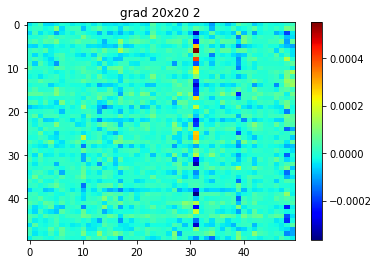

number of nonzero  tensor(2359296)


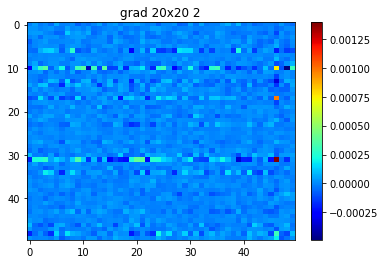

number of nonzero  tensor(2359296)


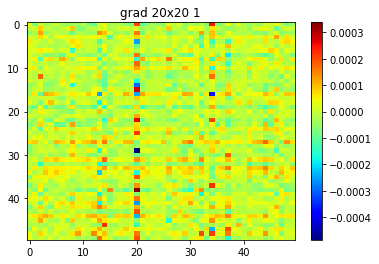

number of nonzero  tensor(2359296)


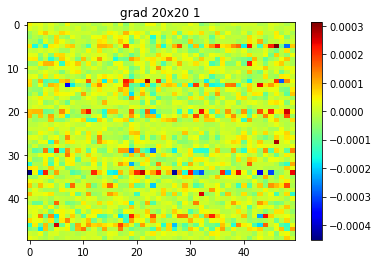

number of nonzero  tensor(2359296)


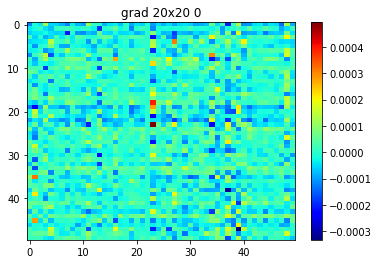

number of nonzero  tensor(2359296)


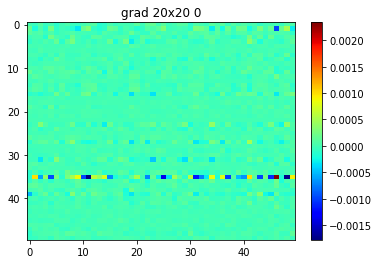

Step,Training Loss,Validation Loss,Matthews Correlation,Combined Score
100,No log,0.512368,0.420689,0.420689
200,No log,0.472750,0.452581,0.452581
300,No log,0.444329,0.512777,0.512777
400,No log,0.425457,0.534143,0.534143
500,0.489300,0.417430,0.567827,0.567827


RuntimeError: Trace is already saved

In [29]:
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU,
                                        torch.profiler.ProfilerActivity.CUDA], 
                            schedule=torch.profiler.schedule(skip_first=3, wait=1, warmup=1, active=2, repeat=2),
                            on_trace_ready=torch.profiler.tensorboard_trace_handler('hf-training-trainer'),
                            profile_memory=True,
                            with_stack=True,
                            record_shapes=True) as prof:
    
    trainer.add_callback(ProfCallback(prof=prof))
    train_result = trainer.train()
    prof.export_chrome_trace(profiler_result_path)

**sparse matrix**

In [28]:
from sparse_grad_matrix_spare_mult_anna import replace_bert_layers

In [29]:
from trainers_custom import TrainerBert1, TrainerBert2

In [30]:
from transformers import TrainingArguments, Trainer, EvalPrediction

In [31]:
training_args1 = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=100,
    max_steps = 30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
#     profiler="simple",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

training_args2 = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    skip_memory_metrics = False,
    eval_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
#     profiler="simple",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [32]:
model = sparse_grad_linear(model)

create bert with sparse grads
created bert with sparse grads


In [34]:
class ProfCallback(TrainerCallback):
    def __init__(self, prof):
        self.prof = prof

    def on_step_end(self, args, state, control, **kwargs):
        self.prof.step()


In [35]:
trainer = TrainerBert1(
        model=model,
        args=training_args1,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics
)
trainer.make_grad_bank()

In [36]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

len small dataset 8551
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


finishing collecting gradients


In [37]:
trainer = TrainerBert2(
        model=model,
        args=training_args2,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics
)
trainer.make_grad_bank()

In [38]:
profiler_result_path = 'file.json'

In [39]:
profiler_result_path = 'file.json'
def train_on_epoch(generator, model, loss_function, optimizer):
    model.train()
    epoch_loss = []
    for batch_of_x, batch_of_y in generator:
        optimizer.zero_grad()
        with torch.autograd.profiler.profile(use_cuda=True, record_shapes=True, with_flops=True, profile_memory=True) as prof:
            output = model(batch_of_x)
            loss = loss_function(output, batch_of_y)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item()) 
    
    prof.export_chrome_trace(profiler_result_path)

created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
number of nonzero  tensor(7680)


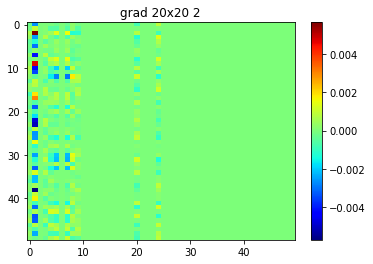

number of nonzero  tensor(804864)


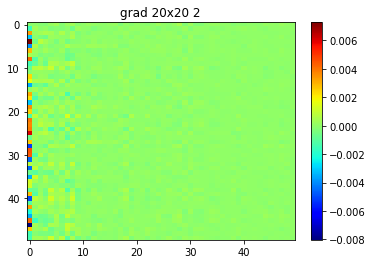

number of nonzero  tensor(4608)


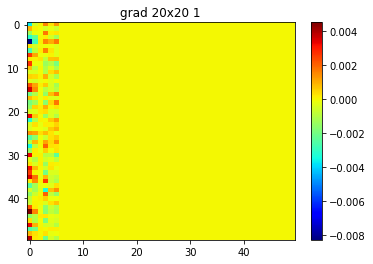

number of nonzero  tensor(543744)


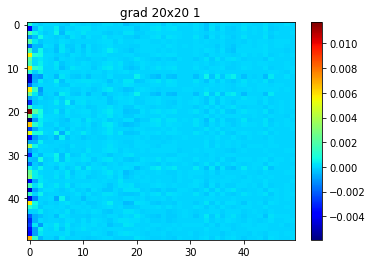

number of nonzero  tensor(5376)


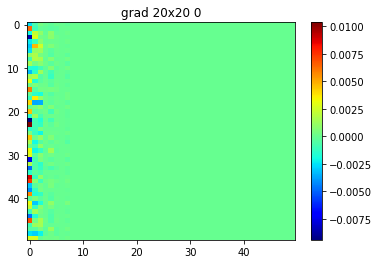

number of nonzero  tensor(463872)


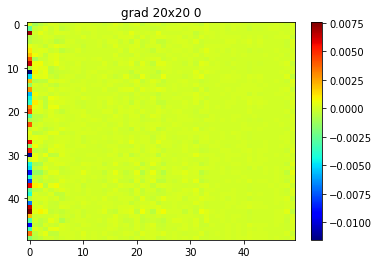

Step,Training Loss,Validation Loss,Matthews Correlation,Combined Score
100,No log,0.616582,0.000000,0.000000
200,No log,0.619959,0.000000,0.000000
300,No log,0.627890,0.000000,0.000000
400,No log,0.619773,0.000000,0.000000
500,0.617000,0.618914,0.000000,0.000000


RuntimeError: Trace is already saved

In [40]:
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU,
                                        torch.profiler.ProfilerActivity.CUDA], 
                            schedule=torch.profiler.schedule(skip_first=3, wait=1, warmup=1, active=2, repeat=2),
                            on_trace_ready=torch.profiler.tensorboard_trace_handler('hf-training-trainer'),
                            profile_memory=True,
                            with_stack=True,
                            record_shapes=True) as prof:
    
    trainer.add_callback(ProfCallback(prof=prof))
    train_result = trainer.train()
    prof.export_chrome_trace(profiler_result_path)

In [ ]:
%mprun trainer.train()

In [ ]:
train_result = trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.log_metrics("train", train_result.metrics)